# Network Science 2024/2025
## Homework 2

**Authors:**  
- Adriano Machado (202105352)  
- Francisco da Ana (202108762)  
- João Lima (202108891)

### Auxiliary code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import collections
import math
import os

In [2]:
class Graph:
    def __init__(self, n: int = None, filename: str = None):
        """
        Initializes a graph with n nodes (with no connections) or loads it from a file.
        Sets all nodes as unvisited.
        """
        if filename:
            with open(filename, 'r') as file:
                first_line = file.readline().strip()
                if first_line:
                    self.n = int(first_line)
                    self.adj_matrix = [[0 for _ in range(self.n)] for _ in range(self.n)]
                for line in file:
                    a, b = map(int, line.strip().split())
                    self.add_edge(a - 1, b - 1)
        elif n is not None:
            self.n = n
            self.adj_matrix = [[0 for _ in range(n)] for _ in range(n)]
        else:
            raise ValueError("Either 'n' or 'filename' must be provided.")
        self.visited = [False] * self.n

    def add_edge(self, a : int, b : int):
        self.adj_matrix[a][b] = 1
        self.adj_matrix[b][a] = 1

    def add_edges(self, a : int, targets : list):
        for target in targets:
            self.add_edge(a, target)
 
    def has_edge(self, a, b):
        return self.adj_matrix[a][b] == 1

    def save_to_file(self, filename):
        with open(filename, 'w') as file:
            file.write(f"{self.n}\n")
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    if self.adj_matrix[i][j] == 1:
                        file.write(f"{i + 1} {j + 1}\n")

    def calculate_giant_component_size(self):
        self._set_all_unvisited()
        max_size = 0
        for i in range(self.n):
            if not self.visited[i]:
                size = self.component_size(i)
                max_size = max(max_size, size)
        return max_size

    def component_size(self, node):
        stack = [node]
        size = 0
        while stack:
            current_node = stack.pop()
            if not self.visited[current_node]:
                self.visited[current_node] = True
                size += 1
                for neighbor in self._get_neighbors(current_node):
                    if not self.visited[neighbor]:
                        stack.append(neighbor)
        return size
    
    def get_degree_of_node(self, node):
        return sum(self.adj_matrix[node])
    
    def _set_all_unvisited(self):
        self.visited = [False] * self.n

    def _get_neighbors(self, node):
        return [i for i in range(self.n) if self.adj_matrix[node][i] == 1]


In [3]:
def get_graph_details(nodes_list, edges_list):
    m = len(edges_list)
    degrees = collections.defaultdict(int)
    adj = collections.defaultdict(list)
    for node in nodes_list:
        _ = degrees[node] 
        _ = adj[node]     
    for u, v in edges_list:
        degrees[u] += 1
        degrees[v] += 1
        adj[u].append(v)
        adj[v].append(u)
    return m, degrees, adj

def draw_simple_graph(nodes, edges, communities, node_id_to_label_map, title="Graph Communities"):
    fig, ax = plt.subplots(figsize=(10, 10)) 
    node_positions = {}
    unique_nodes_for_layout = sorted(list(set(nodes))) 
    num_nodes = len(unique_nodes_for_layout)
    radius = 5 + num_nodes * 0.1 
    center_x, center_y = 0, 0
    angle_step = 2 * math.pi / num_nodes if num_nodes > 0 else 0

    for i, node in enumerate(unique_nodes_for_layout):
        angle = i * angle_step
        node_positions[node] = (center_x + radius * math.cos(angle), 
                                center_y + radius * math.sin(angle))

    unique_comm_ids = sorted(list(set(c_id for c_id in communities.values() if c_id is not None)))
    num_colors = len(unique_comm_ids) if unique_comm_ids else 1
    color_palette = plt.cm.get_cmap('viridis', max(1, num_colors))
    node_to_color = {}

    if unique_comm_ids:
        for node in unique_nodes_for_layout: 
            comm_id = communities.get(node)
            if comm_id is not None and comm_id in unique_comm_ids:
                try:
                    color_idx = unique_comm_ids.index(comm_id)
                    node_to_color[node] = color_palette(color_idx)
                except ValueError: node_to_color[node] = 'lightgrey'
            else: node_to_color[node] = 'lightgrey'
    else: 
        for node in unique_nodes_for_layout:
             node_to_color[node] = color_palette(0) if num_colors > 0 else 'lightgrey'

    for u, v in edges:
        if u in node_positions and v in node_positions:
            x_coords = [node_positions[u][0], node_positions[v][0]]
            y_coords = [node_positions[u][1], node_positions[v][1]]
            ax.plot(x_coords, y_coords, color='gray', linestyle='-', linewidth=0.7, zorder=1)

    for node, pos in node_positions.items():
        node_color_val = node_to_color.get(node, 'lightgrey')
        bg_brightness = sum(node_color_val[:3]) / 3 if isinstance(node_color_val, tuple) else 0.5
        text_color = 'white' if bg_brightness < 0.4 else 'black'
        
        node_display_label = node_id_to_label_map.get(node, str(node)) 
        if len(node_display_label) > 10:
             node_display_label = node_display_label[:8] + "..."

        ax.scatter(pos[0], pos[1], s=800, color=node_color_val, edgecolors='black', zorder=2, alpha=0.8)
        ax.text(pos[0], pos[1], node_display_label, ha='center', va='center', fontsize=7, color=text_color, weight='bold')
        
    ax.set_title(title + " (Movie ID 91)", fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.tight_layout()
    print("Simple community visualization for Movie ID 91 saved as community_visualization_movie1_simple.png")
    plt.show()

### **Link Analysis and PageRank**

#### Exercise 1

   PageRank  Betweenness  Closeness
A    0.0212       0.0000     0.0000
B    0.0302       0.0045     0.0909
C    0.0431       0.1136     0.1818
D    0.0524       0.0364     0.2045
E    0.0840       0.2545     0.2424
F    0.0927       0.2727     0.2066
G    0.1000       0.2727     0.1925
H    0.1062       0.2545     0.1856
I    0.1115       0.2182     0.1818
J    0.1160       0.1636     0.1796
K    0.1198       0.0909     0.1783
L    0.1230       0.0000     0.1774


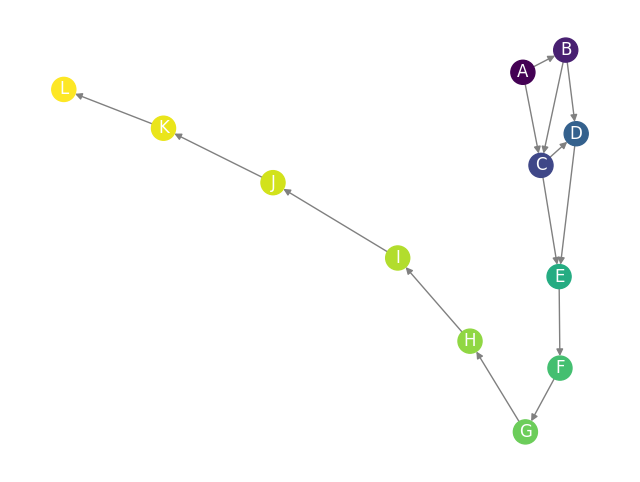

In [4]:
G = nx.DiGraph()

edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('B', 'D'),
    ('C', 'D'),
    ('C', 'E'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'G'),
    ('G', 'H'),
    ('H', 'I'),
    ('I', 'J'),
    ('J', 'K'),
    ('K', 'L'),
]

G.add_edges_from(edges)

pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G, normalized=True)
closeness = nx.closeness_centrality(G)

metrics = pd.DataFrame({
    'PageRank': [round(pagerank[node], 4) for node in G.nodes()],
    'Betweenness': [round(betweenness[node], 4) for node in G.nodes()],
    'Closeness': [round(closeness[node], 4) for node in G.nodes()]
}, index=G.nodes())

print(metrics)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_nodes(G, pos, node_color=[pagerank[node] for node in G.nodes()], 
                       cmap=plt.cm.viridis, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
plt.axis('off')
plt.savefig("docs/ex1_graph.png")
plt.show()

This graph is a candidate for the asked configuration. Node L has the highest PageRank value (0.1230), while its betweeness centrality is 0.0 and its closeness centrality is also one of the lowest in the node set (0.1774).

#### Exercise 2
The damping factor **β** indicates the probability that a surfer will follow an outgoing link from the current node. This also means that there is a probability of **1 - β** that the surfer will jump to any random node in the network, even if there is no link to it.

**a)** In a PageRank setup with `β = 0.0`, the algorithm will not consider existing links/edges at all to calculate the nodes' scores. The only factor that will be considered is the number of nodes in the network. This means that all nodes will have the same score, which is equal to `1/N` (N is the number of nodes in the Graph).

**b)** In a PageRank setup with `β = 1.0`, the algorithm will only consider existing links/edges to calculate the nodes' scores. This may lead to issues in PageRank calculation suach as spider traps and dead ends.
**Spider traps** are groups of pages that only link to each other, trapping all the PageRank score inside that group forever. **Dead ends** are pages with no outgoing links that absorb PageRank but can't pass it on to other pages.

#### Exercise 3

In [5]:
class NormalizedPageRank:
    """
    Calculates the PageRank scores of a graph using the power iteration method.
    PageRank values of all nodes are stored in the page_rank attribute as a numpy array.
    Damping factor is represented by Beta. 
        - Beta represents the probability of following an existing link.
        - 1 - Beta represents the probability of jumping to any random node.
    """
    def __init__(self, graph: Graph, beta: float = 0.85, convergence_threshold: float = 1e-6):
        self.graph = graph
        self.beta = beta
        self.n = graph.n
        self.scores = np.ones(self.n) / self.n
        self.convergence_threshold = convergence_threshold
        self.scores_history = [self.scores.copy()]

    def calculate_scores(self):
        while True:
            new_scores = np.zeros(self.n)
            for j in range(self.n):
                neighbors = self.graph._get_neighbors(j)
                if neighbors:
                    for i in neighbors:
                        new_scores[j] += self.scores[i] / self.graph.get_degree_of_node(i)
            new_scores = (1 - self.beta) / self.n + self.beta * new_scores
            if np.linalg.norm(new_scores - self.scores, ord=1) < self.convergence_threshold:
                break
            self.scores = new_scores
            self.scores_history.append(self.scores.copy())

    def get_top_k_nodes(self, k: int):
        return np.argsort(self.scores)[-k:][::-1]
    
    def get_score_of_node(self, node: int):
        return self.scores[node]
    
    def reset(self):
        self.scores = np.ones(self.n) / self.n
        self.scores_history = [self.scores.copy()]

    def number_of_iterations(self):
        return len(self.scores_history) - 1

#### Exercise 4

In order to compute the PageRank scores of the described network, I've defined it in a `.txt` file stored at `docs/ex4_network.txt`

PR state at it. 0: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
PR state at it. 1: [0.04571429 0.36547619 0.08619048 0.16714286 0.08619048 0.16714286
 0.08214286]
PR state at it. 2: [0.08355952 0.25194048 0.13091667 0.15682143 0.13091667 0.15338095
 0.09246429]
PR state at it. 3: [0.06425845 0.31335298 0.10869119 0.17553762 0.10869119 0.1428531
 0.08661548]
PR state at it. 4: [0.07469858 0.27888399 0.12443424 0.16708609 0.12443424 0.14832173
 0.08214114]
PR state at it. 5: [0.06883885 0.30106926 0.11617991 0.17460795 0.11617991 0.13865882
 0.08446531]
PR state at it. 6: [0.07261035 0.28709677 0.1220826  0.17136327 0.1220826  0.14440586
 0.08035857]
PR state at it. 7: [0.07023502 0.29684299 0.11878795 0.17400523 0.11878795 0.1385398
 0.08280106]
PR state at it. 8: [0.07189188 0.29027899 0.12119336 0.17286163 0.12119336 0.14227278
 0.08030799]
PR state at it. 9: [0.070776   0.29499442 0.11975346 0.17379036 0.11975346 0.13903779
 0.0818945 ]
PR state at 

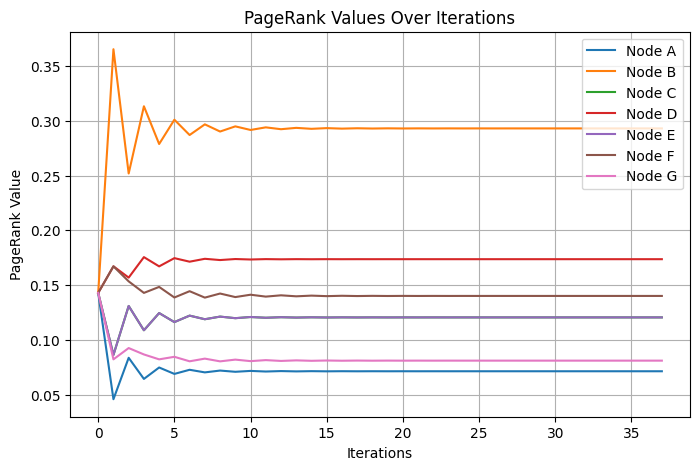

In [6]:
net4 = Graph(filename='docs/ex4_network.txt')
pr = NormalizedPageRank(net4)
pr.calculate_scores()

# Print pageranks to console
for i in range(pr.number_of_iterations()):
    print(f"PR state at it. {i}: {pr.scores_history[i]}")

# Plot pagerank values over iterations
plt.figure(figsize=(8, 5))
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range(pr.n):
    plt.plot(range(pr.number_of_iterations()), [pr.scores_history[j][i] for j in range(pr.number_of_iterations())], label=f'Node {alphabet[i]}')
plt.xlabel('Iterations')
plt.ylabel('PageRank Value')
plt.title('PageRank Values Over Iterations')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('docs/ex4_pagerank_values.png')
plt.show()

#### Exercise 5 a)

In [7]:
betas = np.arange(0.0, 1.05, 0.05)
iterations = []
scores = []
for beta in betas:
    pr = NormalizedPageRank(net4, beta=beta)
    pr.calculate_scores()
    iterations.append(pr.number_of_iterations())
    scores.append(pr.scores.copy())

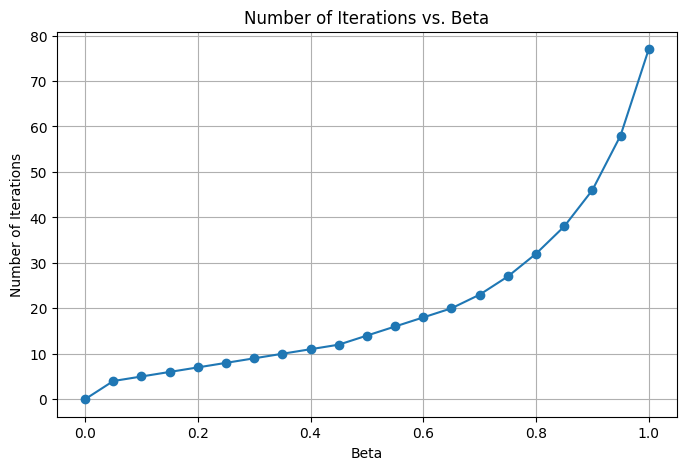

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(betas, iterations, marker='o')
plt.xlabel('Beta')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations vs. Beta')
plt.grid()
plt.savefig('docs/ex5_iterations_vs_beta.png')
plt.show()

As we can see, very low values of **β** lead to a quick convergence of PageRank scores. Increasing the value of **β** leads to a slower convergence as it takes more iterations to be reached. The reason for this is that a higher damping factor places more weight on the link structure, meaning the algorithm needs more iterations for the PageRank to "flow" through the network and stabilize, whereas a lower β relies more on the random jump factor which distributes rank more uniformly and thus converges faster.

#### Exercise 5 b)

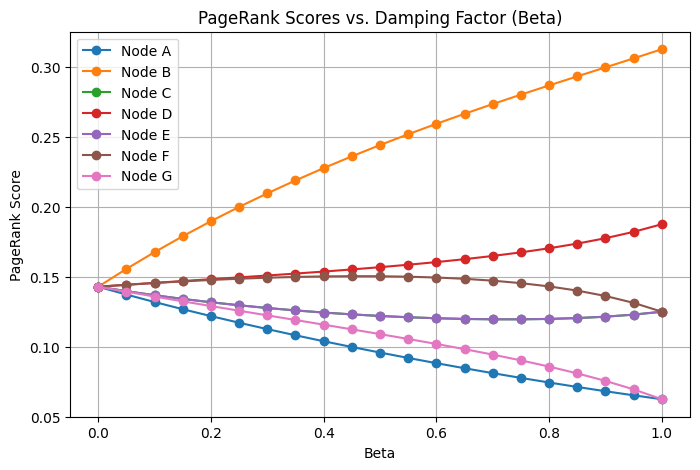

In [9]:
plt.figure(figsize=(8, 5))
for i in range(pr.n):
    plt.plot(betas, [scores[j][i] for j in range(len(betas))], marker='o', label=f'Node {alphabet[i]}')
plt.xlabel('Beta')
plt.ylabel('PageRank Score')
plt.title('PageRank Scores vs. Damping Factor (Beta)')
plt.legend()
plt.grid()
plt.savefig('docs/ex5_pagerank_scores_vs_beta.png')
plt.show()

This plot clearly shows the evolution of PageRank scores when using different values of **β**. When `β=0` all nodes have the same score, which is `1/N` (in this case, approximately 0.143 which correspondes to 1/7). As we increase the value of **β** the scores start to diverge.

Additionally, the plot displays some different curve types: nodes with sharply increasing curves (such as Node B) have a PageRank score that is heavily reliant on and benefits from the link structure. Node D shows a similar but not so heavy behaviour. These nodes become more significant as β (the weight on link-following) rises. On the other hand, nodes that depend more on the the random jump factor (1-β) are represented by steadily decreasing curves (such as Nodes A, E, and G), which become less significant as the link structure takes center stage. Node F exhibits a more intricate pattern, showing a nuanced position within the network and initially benefiting slightly from link structure before its relative importance diminishes at higher β values.

### **Community Discovery**

#### Exercise 6 a)

In [10]:
movies_df = pd.read_csv("movies/movies.csv")

results_table = []
networks = [3, 5, 63, 376, 506, 586]
for net_id in networks:
    movie_name = movies_df.loc[movies_df['ID'] == net_id, 'Title'].values[0]

    nodes_file = f"movies/networks/{net_id}_nodes.csv"
    edges_file = f"movies/networks/{net_id}_edges.csv"
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)
    
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        G.add_node(row['Id'], label=row['Label'])
    
    for _, row in edges_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])
    
    communities = community.louvain_communities(G, weight='weight', seed=42)
    num_communities = len(communities)
    
    modularity = community.modularity(G, communities, weight='weight')
    
    results = {
        'move_db_id': net_id,
        'movie_name': movie_name,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'num_communities': num_communities,
        'modularity': modularity
    }

    results_table.append(results)

results_df = pd.DataFrame(results_table)
results_df

,move_db_id,movie_name,num_nodes,num_edges,num_communities,modularity
0,3,Twelve and Holding,25,47,3,0.473908
1,5,127 Hours,9,10,3,0.117202
2,63,An Education,18,46,3,0.227067
3,376,Halloween: The Curse of Michael Myers,50,181,5,0.346627
4,506,Living in Oblivion,21,91,3,0.070457
5,586,Nashville,40,131,5,0.365642


Among the 6 selected movies, we can say that some of them have a good community structure by looking at their modularity values and defining a threshold of 0.3. 

The movies that have a modularity value above this threshold have ids {3, 376, 586} and are therefore considered to have a good community structure. The other movies {5, 63, 506} have modularity values below this threshold and are therefore not considered to have a good community structure.

#### Exercise 6 b)




Analyzing network for Avatar (ID: 88)

Analyzing network for 2012 (ID: 11)


/tmp/ipykernel_13465/3631517248.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('viridis', max(node_colors) + 1), alpha=0.8)
/tmp/ipykernel_13465/3631517248.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('viridis', max(node_colors) + 1), alpha=0.8)


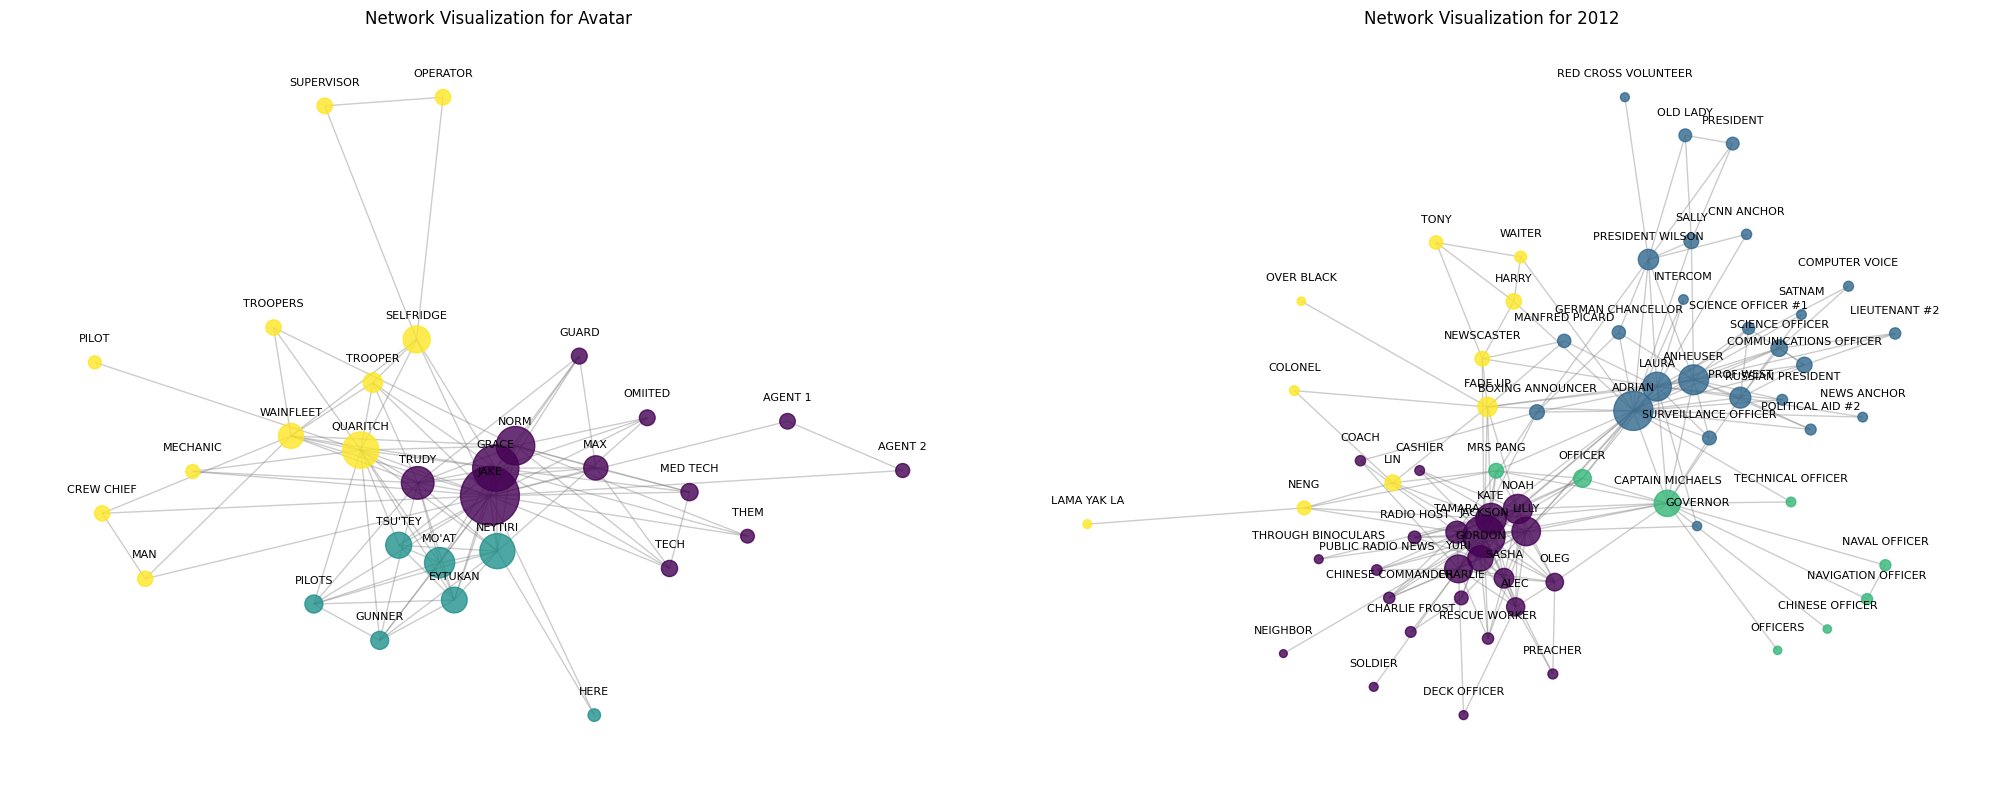

In [11]:
net_ids = [88, 11] # choose any two movie IDs from the dataset (preference for known movies)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, net_id in enumerate(net_ids):
    movie_name = movies_df.loc[movies_df['ID'] == net_id, 'Title'].values[0]
    print(f"\nAnalyzing network for {movie_name} (ID: {net_id})")

    nodes_file = f"movies/networks/{net_id}_nodes.csv"
    edges_file = f"movies/networks/{net_id}_edges.csv"
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)

    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        G.add_node(row['Id'], label=row['Label'])
    
    for _, row in edges_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    pagerank = nx.pagerank(G, weight='weight')

    for node, rank in pagerank.items():
        G.nodes[node]['pagerank'] = rank

    communities = community.louvain_communities(G, weight='weight', seed=42)
    for i, comm in enumerate(communities):
        for node in comm:
            G.nodes[node]['community'] = i

    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}

    pos = nx.spring_layout(G, seed=42)
    node_colors = [G.nodes[node]['community'] for node in G.nodes()]
    node_sizes = [G.nodes[node]['pagerank'] * 10000 for node in G.nodes()]
    
    plt.sca(axes[idx])
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                            cmap=plt.cm.get_cmap('viridis', max(node_colors) + 1), alpha=0.8)
    label_pos = {node: (x, y + 0.05) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, labels=node_labels, font_size=8, verticalalignment='bottom')

    plt.title(f"Network Visualization for {movie_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Avatar**

The three communities shown in the plot correspond to:
- **Yellow – Human Command & Troops:** RDA officers, pilots, mechanics and ground‐troops (e.g. Supervisor, Wainfleet, Troopers).
- **Blue – Na’vi Clan:** Omaticaya characters and close-knit clan (Neytiri, Eytukan, Ts’utey, Mo’at).
- **Purple – Science & the Bridge:** Jake (Sully), Grace, Norm, Trudy, medical/security staff—who interact heavily with **both** the humans and the Na’vi, making Jake the network’s central “bridge.”

**2012**

Analyzing the network of the movie 2012, we identified four distinct communities:
- **Purple - The main survivor group:** Centered around the Curtis family and their allies.
- **Blue - The establishment:** Comprised of government officials, scientists, and decision-makers.
- **Yellow - The early observers of the apocalypse:** Those who discover the disaster early, provide aid, or represent the broader society.
- **Green - Ark operational crew:** Those responsible for operating humanity's last refuge vessels.

#### Exercise 6 c)

In [12]:
def calculate_manual_modularity(graph, partition, weight_attribute='weight'):

    if not graph.nodes() or not graph.edges():
        return 0.0

    node_to_community_map = {}
    for community_id, community_nodes in enumerate(partition):
        for node in community_nodes:
            node_to_community_map[node] = community_id

    if not node_to_community_map:
        return 0.0

    total_weighted_degrees = 0.0
    if weight_attribute:
        for node in graph.nodes():
            total_weighted_degrees += graph.degree(node, weight=weight_attribute)
    else: 
        total_weighted_degrees = 2 * graph.number_of_edges()
    
    two_m = total_weighted_degrees

    if two_m == 0:
        return 0.0

    modularity_sum_numerator = 0.0

    node_list = list(graph.nodes())
    for node_i in node_list:
        for node_j in node_list:
            if node_to_community_map.get(node_i) == node_to_community_map.get(node_j):
                a_ij = 0.0
                if graph.has_edge(node_i, node_j):
                    if weight_attribute:
                        a_ij = graph[node_i][node_j].get(weight_attribute, 1.0) 
                    else:
                        a_ij = 1.0 
                
                k_i = graph.degree(node_i, weight=weight_attribute) if weight_attribute else graph.degree(node_i)
                k_j = graph.degree(node_j, weight=weight_attribute) if weight_attribute else graph.degree(node_j)

                modularity_sum_numerator += (a_ij - (k_i * k_j) / two_m)

    return modularity_sum_numerator / two_m

### **Explanation of the code**
The program follows these main steps:
- **Community Mapping:** First, it creates a dictionary that associates each node with its community's identifier, based on the provided partition.
- **Calculation of 2m:** It calculates the value of 2m, which is the sum of all (weighted, if applicable) degrees in the graph. This value is crucial for normalization in the modularity formula.
- **Summing Modularity** Terms: It iterates over all possible pairs of nodes (i,j) in the network.
    - For each pair, it checks if both nodes belong to the same community.
    - If they are in the same community, it calculates the term (Aij − (ki * kj)/2m) and adds it to an accumulated sum. Aij represents the (weighted) connection between i and j, and ki, kj are their (weighted) degrees.
- **Final Result:** The modularity is obtained by dividing the accumulated sum by 2m.


The next part is relevant to testing with a movie of our choice and the partitions produced before.

In [13]:
import pandas as pd
import networkx as nx
import networkx.algorithms.community as community 

def test_modularity_for_movie(movie_id, movies_metadata_df, data_base_path="movies/"):

    nodes_file = f"{data_base_path}networks/{movie_id}_nodes.csv"
    edges_file = f"{data_base_path}networks/{movie_id}_edges.csv"

    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)

    G = nx.Graph()
    try:
        for _, row in nodes_df.iterrows():
            G.add_node(row['Id'], label=row['Label'])
        for _, row in edges_df.iterrows():
            G.add_edge(row['Source'], row['Target'], weight=row['Weight'])
    except KeyError as e:
        print(f"CSV file for movie ID {movie_id} is missing an expected column: {e}. Skipping.")
        return
    except Exception as e:
        print(f"Error building graph for movie ID {movie_id}: {e}. Skipping.")
        return

    louvain_comms = community.louvain_communities(G, weight='weight', seed=42)
    partition_to_test = [set(comm) for comm in louvain_comms]

    if not partition_to_test and G.nodes():
        print(f"Warning: Louvain resulted in an empty partition for movie ID {movie_id}, creating default.")
        partition_to_test = [{node} for node in G.nodes()]


    print(f"Number of communities found by Louvain: {len(partition_to_test)}")

    try:
        manual_mod_value = calculate_manual_modularity(G, partition_to_test, weight_attribute='weight')
        print(f"Manually calculated modularity: {manual_mod_value:.6f}")
    except Exception as e:
        print(f"Error during manual modularity calculation: {e}")
        manual_mod_value = None 

    try:
        networkx_mod_value = community.modularity(G, partition_to_test, weight='weight')
        print(f"NetworkX calculated modularity:  {networkx_mod_value:.6f}")
    except Exception as e:
        print(f"Error during NetworkX modularity calculation: {e}")
        networkx_mod_value = None 

    if manual_mod_value is not None and networkx_mod_value is not None:
        if abs(manual_mod_value - networkx_mod_value) < 1e-9:
            print("SUCCESS: Manual modularity matches NetworkX modularity.")
        else:
            print("MISMATCH: Manual modularity differs from NetworkX modularity.")
    else:
        print("Could not compare modularity values due to an error in calculation.")

if __name__ == "__main__":
    data_directory_path = "movies/"

    movies_csv_path = f"{data_directory_path}movies.csv"
    try:
        all_movies_df = pd.read_csv(movies_csv_path)
    except FileNotFoundError:
        print(f"CRITICAL ERROR: The main movie metadata file '{movies_csv_path}' was not found.")
        print("Please ensure the path is correct and the file exists. Cannot proceed with tests.")
        exit()
    except Exception as e:
        print(f"CRITICAL ERROR: Could not read '{movies_csv_path}': {e}. Cannot proceed.")
        exit()

    if 'ID' not in all_movies_df.columns or 'Title' not in all_movies_df.columns:
        print("CRITICAL ERROR: 'movies.csv' is missing 'ID' or 'Title' columns. Cannot proceed.")
        exit()

    specific_test_id = 91
    print(f"=== Testing specific movie ID: {specific_test_id} ===")
    test_modularity_for_movie(specific_test_id, all_movies_df, data_directory_path)

    ids_from_6a = [3, 5, 63, 376, 506, 586]
    print(f"\n=== Testing movie IDs from task 6a: {ids_from_6a} ===")
    for movie_id_6a in ids_from_6a:
        test_modularity_for_movie(movie_id_6a, all_movies_df, data_directory_path)

    print("\n--- All specified tests complete. ---")

=== Testing specific movie ID: 91 ===
Number of communities found by Louvain: 4
Manually calculated modularity: 0.292753
NetworkX calculated modularity:  0.292753
SUCCESS: Manual modularity matches NetworkX modularity.

=== Testing movie IDs from task 6a: [3, 5, 63, 376, 506, 586] ===
Number of communities found by Louvain: 3
Manually calculated modularity: 0.473908
NetworkX calculated modularity:  0.473908
SUCCESS: Manual modularity matches NetworkX modularity.
Number of communities found by Louvain: 3
Manually calculated modularity: 0.117202
NetworkX calculated modularity:  0.117202
SUCCESS: Manual modularity matches NetworkX modularity.
Number of communities found by Louvain: 3
Manually calculated modularity: 0.227067
NetworkX calculated modularity:  0.227067
SUCCESS: Manual modularity matches NetworkX modularity.
Number of communities found by Louvain: 5
Manually calculated modularity: 0.346627
NetworkX calculated modularity:  0.346627
SUCCESS: Manual modularity matches NetworkX mo

#### Exercise 6 d)

In [14]:
def calculate_modularity(graph_nodes, graph_edges, communities, m, degrees):
    Q = 0.0
    
    if communities is None or not isinstance(communities, dict):
        return 0.0
    
    unique_community_ids = set(communities.values())
    
    for comm_id in unique_community_ids:
        nodes_in_comm = {node for node, c_id in communities.items() if c_id == comm_id}
        if not nodes_in_comm: continue
        L_c = 0
        d_c = 0
        for u, v in graph_edges: 
            if communities.get(u) == comm_id and communities.get(v) == comm_id: L_c += 1 
        for node in nodes_in_comm: d_c += degrees.get(node, 0)
        if m == 0: return 0.0
        term1 = L_c / m if m > 0 else 0.0
        term2 = (d_c / (2 * m))**2 if m > 0 else 0.0
        Q += (term1 - term2)

    return Q

def greedy_agglomerative_modularity_with_tracking(nodes_list, edges_list):
    if not nodes_list: return {}, []
    m, degrees, adj = get_graph_details(nodes_list, edges_list)
    communities = {node: node for node in nodes_list} 
    modularity_over_iterations = []
    current_modularity = calculate_modularity(nodes_list, edges_list, communities, m, degrees)
    modularity_over_iterations.append(current_modularity)

    while True:
        best_overall_delta_Q = 0.0
        node_to_move = None
        target_community_id_for_node = None
        current_unique_communities = set(communities.values())

        for node_i in nodes_list: 
            community_i_id = communities[node_i]
            d_C_old = 0 
            nodes_in_C_old = [n for n, cid in communities.items() if cid == community_i_id]

            for n_in_old in nodes_in_C_old: d_C_old += degrees.get(n_in_old,0)
            
            k_i_C_old_others = 0 
            
            for neighbor in adj.get(node_i, []): 
                if communities.get(neighbor) == community_i_id and neighbor != node_i: k_i_C_old_others += 1
            
            for target_comm_id in current_unique_communities:
                if target_comm_id == community_i_id: continue
                
                d_C_new = 0 
                nodes_in_C_new = [n for n, cid in communities.items() if cid == target_comm_id]
                
                for n_in_new in nodes_in_C_new: d_C_new += degrees.get(n_in_new,0)
                k_i_C_new = 0 
                
                for neighbor in adj.get(node_i,[]):
                    if communities.get(neighbor) == target_comm_id: k_i_C_new += 1
                
                delta_Q = 0.0
                
                if m > 0:
                    gain_adding_to_C_new = (k_i_C_new / m) - (degrees.get(node_i,0) * d_C_new) / (2 * m**2)
                    loss_removing_from_C_old = (k_i_C_old_others / m) - (degrees.get(node_i,0) * (d_C_old - degrees.get(node_i,0))) / (2 * m**2)
                    delta_Q = gain_adding_to_C_new - loss_removing_from_C_old
                
                if delta_Q > best_overall_delta_Q:
                    best_overall_delta_Q = delta_Q
                    node_to_move = node_i
                    target_community_id_for_node = target_comm_id
        
        if best_overall_delta_Q > 1e-9: 
            if node_to_move is not None: 
                 communities[node_to_move] = target_community_id_for_node
                 current_modularity += best_overall_delta_Q 
                 modularity_over_iterations.append(current_modularity)
            else: break
        else: break 
    return communities, modularity_over_iterations



### **Explanation of the code**
This Python code consists of two main functions designed for community detection in networks by optimizing modularity.

### 1. `calculate_modularity`

- **Purpose:** Computes the modularity score (Q) for a graph given a specific partition of its nodes into communities.
- **How it works:**
    - It takes the graph's edges, the current community assignments for each node, the total number of edges (`m`), and pre-calculated node degrees as input.
    - For each community, it calculates:
        - `L_c`: The number of edges entirely within that community.
        - `d_c`: The sum of degrees of all nodes within that community.
    - It then sums the term `(L_c / m) - (d_c / (2m))^2` for all communities to get the final modularity score Q.
- **Output:** A single float value representing the modularity of the given partition.

### 2. `greedy_agglomerative_modularity_with_tracking`

- **Purpose:** Implements a greedy algorithm to find community structures by iteratively optimizing modularity. It also tracks the modularity score at each step.
- **How it works:**
    1.  **Initialization:**
        - It starts by placing each node in its own community.
        - It calculates the initial modularity of this state.
        - (It assumes an external function `get_graph_details` provides total edges `m`, node `degrees`, and an adjacency list `adj`.)
    2.  **Iterative Optimization:**
        - The algorithm repeatedly searches for the single best node move (i.e., moving a node from its current community to another existing community) that results in the largest positive increase in modularity (`delta_Q`).
        - If such a move is found, the node's community is updated, and the new modularity score is recorded.
        - This process continues until no single node move can further increase the overall modularity.
- **Output:**
    - The final community assignments (dictionary mapping nodes to community IDs).
    - A list of modularity scores, showing its evolution throughout the optimization process.

Successfully loaded 52 nodes and 261 edges for Movie ID 91.
Running community detection for Movie ID 91 ('Awakenings')...
Modularity plot for Movie ID 91 saved as modularity_increase_movie91.png


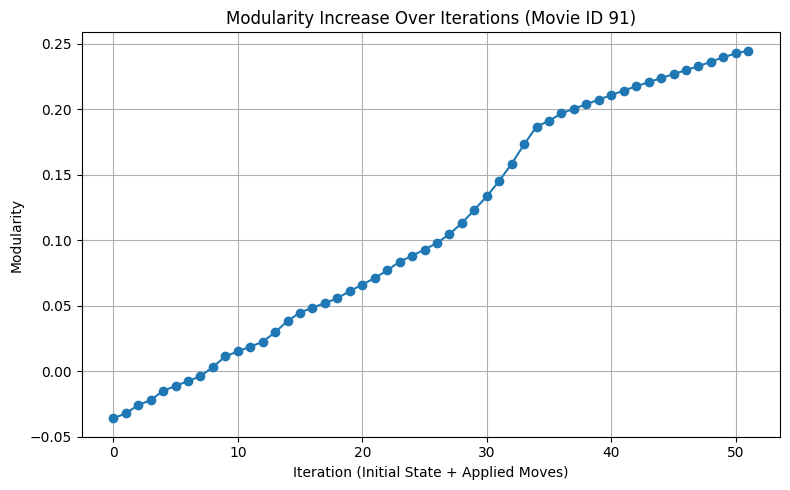


Final Communities for Movie ID 91 (Character Names):
Community (Original ID 540576): DR KAUFMAN, DR SULLIVAN, DR TYLER, FERNANDO, MISS COSTELLO, MISS COSTELLO OS, NO, NURSE
Community (Original ID 540652): LOLLY, PAULA OS, SIDNEY
Community (Original ID 541032): ID, MANN, MRS COHEN, OLD DOCTOR, SAYER, SULLIVAN, WAITER
Community (Original ID 541267): ANTHONY, BERT, BETH, DAUGHTER, FRANCIS, FRANK, LUCY, LUIS, MARGARET, MARGARET OS, MIRIAM, NURSE 1, NURSE 2, ORDERLY, PAULA, RAY, ROSE
Community (Original ID 541828): NEUROCHEMIST, SAYER OS
Community (Original ID 543922): BUS DRIVER, HECTOR, JANITOR, LEONARD, MOVER 1, MOVER 2, MRS LOWE, REV 10/2/89
Community (Original ID 544149): 77ACONT KAUFMAN 77A, DIRECTOR, KAUFMAN, LEONARD -, LEONARD OS, PSYCHIATRIST, WARD 5 PATIENT
Simple community visualization for Movie ID 91 saved as community_visualization_movie1_simple.png


/tmp/ipykernel_13465/219639590.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('viridis', max(1, num_colors))


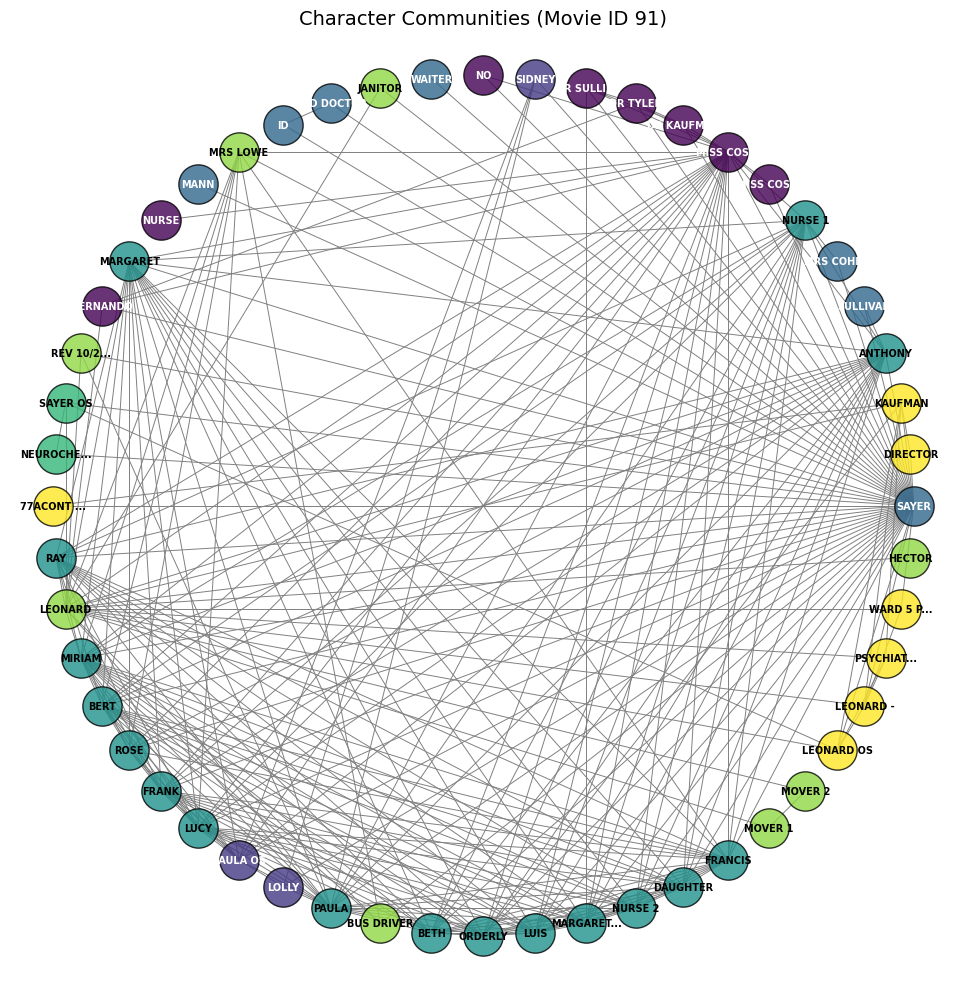


Modularity values at each step for Movie ID 91: [-0.03610487221268039, -0.0323028141101863, -0.025990516874385295, -0.022188458771891205, -0.01514217348541567, -0.01136947490494856, -0.007655495368535412, -0.003941515832122265, 0.003016690888272327, 0.01128139633886759, 0.014980696114267247, 0.018665316128653412, 0.022349936143039578, 0.029682476769278182, 0.038299496484197226, 0.04472923180810615, 0.048384492300465334, 0.05203241291231777, 0.05559959483859601, 0.06116322426270898, 0.06600020551665417, 0.07107940282732195, 0.07686322866663728, 0.08354251992777555, 0.08805654643942394, 0.09284214852982191, 0.09786262679643573, 0.10459329722112122, 0.11303415980387838, 0.1231852145447072, 0.13349040677617766, 0.14524889534798371, 0.15846068026012533, 0.17312576151260253, 0.18682197853818935, 0.19106442947108818, 0.1968776148324305, 0.20040075747566827, 0.20389454059687906, 0.20737364395707636, 0.21083806755626017, 0.21429515127493723, 0.21755405821993218, 0.2206955270768192, 0.223807636

In [15]:
movie_nodes = []
node_id_to_label = {}
movie_edges = []

nodes_df = pd.read_csv('movies/networks/91_nodes.csv')
edges_df = pd.read_csv('movies/networks/91_edges.csv')

movie_nodes = list(nodes_df['Id'].astype(int)) 
node_id_to_label = pd.Series(nodes_df.Label.values, index=nodes_df.Id.astype(int)).to_dict()
movie_edges = list(zip(edges_df['Source'].astype(int), edges_df['Target'].astype(int)))
    
print(f"Successfully loaded {len(movie_nodes)} nodes and {len(movie_edges)} edges for Movie ID 91.")

print("Running community detection for Movie ID 91 ('Awakenings')...")
final_communities_movie1, modularity_values_movie1 = greedy_agglomerative_modularity_with_tracking(movie_nodes, movie_edges)

plt.figure(figsize=(8, 5)) 
plt.plot(range(len(modularity_values_movie1)), modularity_values_movie1, marker='o', linestyle='-')
plt.xlabel("Iteration (Initial State + Applied Moves)")
plt.ylabel("Modularity")
plt.title("Modularity Increase Over Iterations (Movie ID 91)")
plt.grid(True)
plt.tight_layout()
print("Modularity plot for Movie ID 91 saved as modularity_increase_movie91.png")
plt.show() 

print("\nFinal Communities for Movie ID 91 (Character Names):")
grouped_communities_movie1 = collections.defaultdict(list)
for node_id in movie_nodes: 
    comm_id = final_communities_movie1.get(node_id, node_id) 
    character_name = node_id_to_label.get(node_id, f"ID:{node_id}") 
    grouped_communities_movie1[comm_id].append(character_name)

final_community_structure_str_movie1 = []
for comm_id, members in sorted(grouped_communities_movie1.items()):
    str_output = f"Community (Original ID {comm_id}): {', '.join(sorted(members))}"
    print(str_output)
    final_community_structure_str_movie1.append(str_output)

draw_simple_graph(movie_nodes, movie_edges, final_communities_movie1, node_id_to_label, title="Character Communities")

print(f"\nModularity values at each step for Movie ID 91: {modularity_values_movie1}")

print("\nComparison for Movie ID 91 ('10 Things I Hate About You'):")
print("The communities found are listed above with character names.")
print("Since no prior community structure for this movie was provided for algorithmic comparison,")
print("you can compare these groupings to your knowledge of the movie's plot and character interactions.")

m_final_movie1, degrees_final_movie1, _ = get_graph_details(movie_nodes, movie_edges)
if final_communities_movie1 : 
    q_val_final_movie1 = calculate_modularity(movie_nodes, movie_edges, final_communities_movie1, m_final_movie1, degrees_final_movie1)
    print(f"Final calculated modularity for Movie ID 91: {q_val_final_movie1:.4f}")
if modularity_values_movie1:
    print(f"Peak modularity from tracking for Movie ID 91: {modularity_values_movie1[-1]:.4f}")


#### Exercise 6 e)

### **Influencing the Number of Communities in Modularity-Based Greedy Agglomeration**
The `greedy_agglomerative_modularity_with_tracking` algorithm is designed to find a community structure that maximizes a global modularity score. The number of communities it identifies is an emergent property of this optimization process and the inherent structure of the network. However, the granularity of the resulting partition (i.e., the number and size of communities) can be influenced by several approaches.

**To Obtain a Larger Quantity of Communities (Finer-grained Partition)**

A common and theoretically grounded method to obtain more, smaller communities is to introduce a resolution parameter (γ) into the modularity formula. The standard modularity formula can be generalized as:

$Q_{\gamma} = \sum_{c \in C} \left( \frac{L_c}{m} - \gamma \left( \frac{d_c}{2m} \right)^2 \right)$

- **Mechanism:** By setting this resolution parameter γ > 1.0, the penalty for larger communities (represented by the term involving the sum of degrees d_c) is increased. This makes it less advantageous for the algorithm to merge smaller groups into very large ones, as the modularity gain for such merges would be diminished or even become negative. Consequently, the algorithm tends to stabilize with a larger number of smaller communities.
- **Implementation Impact:** This requires modifying both the main modularity calculation function and, more importantly, the $\Delta Q$ (change in modularity) calculation used to evaluate potential node moves during the greedy optimization process. The $\Delta Q$ formula for moving a node i from an old community (C_old) to a new one (C_new) would become:
$\Delta Q_{\gamma} = \left(\frac{k_{i,C_{new}}}{m} - \gamma \frac{k_i d_{C_{new}}}{2m^2}\right) - \left(\frac{k_{i,C_{old\_others}}}{m} - \gamma \frac{k_i (d_{C_{old}} - k_i)}{2m^2}\right)$
where k_i,C is the number of edges from node i to community C, and d_C is the sum of degrees in community C (before the move for C_new, and including i for d_C_old).


**To Obtain a Smaller Quantity of Communities (Coarser-grained Partition)**
Similarly, adjustments can be made to encourage the formation of fewer, larger communities:

- **1: Lower Resolution Parameter (γ<1.0):**
    - **Mechanism:** Using a resolution parameter 0<γ<1.0 in the generalized modularity formula reduces the penalty associated with community size. This makes it more attractive for the algorithm to merge existing communities, leading to a coarser partition with fewer, larger communities.
    - **Implementation Impact:** The same modifications to the modularity and ΔQ formulas as described above would apply, but with a γ value less than 1.

- **2: Hierarchical Agglomeration (Second Pass):**
    - **Mechanism:** The `greedy_agglomerative_modularity_with_tracking` algorithm is analogous to the first phase of multi-level algorithms like the Louvain method. To obtain fewer communities, a second phase can be implemented:
        - The communities found in the first pass are treated as individual "super-nodes" in a new, condensed graph.
        - Edges between these super-nodes are defined based on the edges between the original nodes in their respective communities.
        - The same greedy modularity optimization algorithm is then applied to this condensed graph.
    - **Implementation Impact:** This is a significant extension, requiring the construction of the new graph and re-application of the community detection logic. This hierarchical approach naturally leads to fewer communities at higher levels of aggregation.


### **Network Motifs**

#### Exercise 7 a)

In [17]:
def parse_gtriescanner_results(filepath="results.txt"):
    subgraphs = []
    lines = []
    
    with open(filepath, 'r') as f:
        for line_num, line_raw in enumerate(f):
            stripped_line = line_raw.strip()
            if not stripped_line.startswith('['):
                lines.append(stripped_line)

    start_parsing = False
    matrix_buffer = []
    for i, line in enumerate(lines):

        if "Motif Analysis Results" in line:
            start_parsing = True
            continue

        if start_parsing:
            if not line:
                if len(matrix_buffer) > 0 and len(matrix_buffer) < 4:
                    matrix_buffer = []
                continue

            is_matrix_row_format = (len(line) >= 4 and all(c in '01' for c in line[:4]))
            
            contains_frequency_marker = ("|" in line)

            if is_matrix_row_format and not contains_frequency_marker:
                matrix_buffer.append(line)
                continue
            
            if is_matrix_row_format and contains_frequency_marker:
                matrix_buffer.append(line[:4]) 
                if len(matrix_buffer) == 4: 
                    parts = line.split("|")
                    freq_str = parts[0].strip().split()[-1]
                    current_frequency = int(freq_str)

                    if current_frequency is not None:
                        subgraphs.append({
                            "matrix": tuple(matrix_buffer),
                            "frequency": current_frequency
                        })                    
                    matrix_buffer = [] 
                    continue

    print(f"Total subgraphs found at end: {len(subgraphs)}")
    return subgraphs

def draw_graph_from_adjacency_matrix(matrix_tuple, filename="subgraph.png", title="Subgraph"):
    """
    Draws a graph from its adjacency matrix and saves it as a PNG file.
    """
    G = nx.Graph()
    num_nodes = len(matrix_tuple)

    G.add_nodes_from(range(num_nodes)) 

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if matrix_tuple[i][j] == '1':
                G.add_edge(i, j)

    plt.figure(figsize=(3.5, 3.5))
    pos = nx.shell_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=800, font_size=8, font_weight='bold',
            edgecolors='black', linewidths=1.0)

    plt.title(title)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

results_data = parse_gtriescanner_results("docs/ex_7a_results.txt")

output_dir = "subgraph_images/ex_7a/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

unique_subgraphs = {}
for sg in results_data:
    matrix_key = sg['matrix']
    if matrix_key not in unique_subgraphs:
        unique_subgraphs[matrix_key] = {
            "frequency": 0,
            "image_path": ""
        }
    unique_subgraphs[matrix_key]["frequency"] += sg['frequency']

for i, (matrix_tuple, data) in enumerate(unique_subgraphs.items()):
    image_filename = os.path.join(output_dir, f"subgraph_{i+1}.png")

    draw_graph_from_adjacency_matrix(
        matrix_tuple,
        filename=image_filename,
        title=f"Subgraph {i+1}"
    )
    data["image_path"] = image_filename

Total subgraphs found at end: 5


|           |                                                             |                                                 |                                                 |                                                 |                                                 |
|-----------|:-----------------------------------:|:-----------------------------------:|:-----------------------------------:|:-----------------------------------:|:-----------------------------------:|
|           | ![subgraph_1](docs/subgraph_1.png)  | ![subgraph_2](docs/subgraph_2.png)  | ![subgraph_3](docs/subgraph_3.png)  | ![subgraph_4](docs/subgraph_4.png)  | ![subgraph_5](docs/subgraph_5.png)  |
| Frequency | 21                                  | 5                                   | 4                                   | 1                                   | 1                                   |


#### Exercise 7 b)

### Imagine you have a Gnp undirected ErdosRenyi random network. What is its expected number of triangles? And what about the expected number of chains? Justify your answer.

- Expected Number of Triangles (K3)
A triangle (or K3) is a complete subgraph with 3 nodes.
    - **: Identify all possible triangles:** To form a triangle, you need to choose any 3 distinct nodes from the n available nodes. The number of ways to choose 3 nodes from n is given by the binomial coefficient nC3.
        - nC3 = n(n-1)(n-2) / (3 * 2 * 1)
    - **2: Probability of a single triangle:** For any chosen set of 3 nodes, a triangle is formed if and only if all 3 possible edges between them exist.
        - Edge between node 1 and node 2: probability p
        - Edge between node 2 and node 3: probability p
        - Edge between node 3 and node 1: probability p 
        - Since each edge is independent, the probability that all 3 edges exist is p * p * p = p^3.
    - **3: Expected number of triangles:** The expected number of triangles is the product of the number of possible triangles and the probability that any given triangle exists.
        - E(triangles) = nC3 * p^3 = (n(n-1)(n-2) / 6) * p^3

- Expected Number of Chains (P3)
A chain of length 2 (or P3) is a path graph with 3 nodes and 2 edges. It looks like Node A - Node B - Node C, where A, B, and C are distinct nodes.
    - **1: Identify all possible chains:** To form a chain of length 2, we need to choose 3 distinct nodes and specify which one is the "center" node (B) and which are the "endpoints" (A and C).
        - Choose 3 distinct nodes from n: nC3 ways.
        - Once 3 nodes are chosen, any of them can be the center. There are 3 choices for the center node. (e.g., if nodes are {X, Y, Z}, X can be center, or Y, or Z).
        - The two remaining nodes will be the endpoints. So, the number of ordered triplets of distinct nodes (A,B,C) where A−B and B−C exist (but A−C might or might not) is n(n−1)(n−2). This is because we choose a first node (A), then a second (B), then a third (C). The edges are (A,B) and (B,C). The number of ways to pick 3 distinct nodes and arrange them into a P3 is n(n−1)(n−2).
    - **2: Probability of a single chain:** For any chosen set of 3 nodes ordered as A, B, C, a chain A-B-C is formed if and only if the edge (A,B) exists AND the edge (B,C) exists. The edge (A,C) does not matter for it to be a P3.
        - Edge (A,B): probability p
        - Edge (B,C): probability p Since edges are independent, the probability that these 2 edges exist is p * p=p^2
    - **3: Expected number of chains:** The expected number of chains is the product of the number of possible ordered chains and the probability that any given ordered chain exists.
        - E(chains)=n(n−1)(n−2)p^2

#### Exercise 7 c)

#### Exercise 7 d)

#### Exercise 7 e)